# Learning Disentangled Representations using sequential images of a teapot

In [1]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import os

### Create dataset

Code to generate this dataset borrows from
https://medium.com/@yzhong.cs/beyond-data-scientist-3d-plots-in-python-with-examples-2a8bd7aa654b

The following cells generate sequential images of a teapot, where at each step an action, corresponding to either a rotation in viewpoint or a change in colour, was performed to generate the next image.

In [2]:
CREATE_DATASET = True

First load teapot object, which is borrowed from the Stanford Computer Graphics Lab at https://graphics.stanford.edu/courses/cs148-10-summer/as3/code/as3/teapot.obj

In [3]:
# Load teapot.obj

if CREATE_DATASET:

    import numpy as np
    def read_obj(filename):
        triangles = []
        vertices = []
        with open(filename) as file:
            for line in file:
                components = line.strip(' \n').split(' ')
                if components[0] == "f": # face data
                    # e.g. "f 1/1/1/ 2/2/2 3/3/3 4/4/4 ..."
                    indices = list(map(lambda c: int(c.split('/')[0]) - 1, components[1:]))
                    for i in range(0, len(indices) - 2):
                        triangles.append(indices[i: i+3])
                elif components[0] == "v": # vertex data
                    # e.g. "v  30.2180 89.5757 -76.8089"
                    vertex = list(map(lambda c: float(c), components[1:]))
                    vertices.append(vertex)
        return np.array(vertices), np.array(triangles)

Now generate a dataset, consisting of 1000 sequential images

In [4]:
if CREATE_DATASET:
    
    N_DATA = 1000
    
    folder = 'teapot/'

    vertices, triangles = read_obj(folder+'teapot.obj')
    angle = 2*np.pi / 5
    colors = [[0,0,0],[255,0,0],[255,255,255],[0,255,0],[0,0,255]]
    color_index = 0
    actions = []

    for i in tqdm(range(N_DATA)):
        
        # First, plot 3D image of a teapot and save as image

        x = np.asarray(vertices[:,0]).squeeze()
        y = np.asarray(vertices[:,1]).squeeze()
        z = np.asarray(vertices[:,2]).squeeze()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.grid(None)
        ax.axis('off')
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([0, 3])
        ax.plot_trisurf(x, z, triangles, y, shade=True, color='white')
        ax.view_init(100, angle)
        plt.savefig(folder+'teapot'+str(i)+'.png')
        plt.close()
        
        # Then load the image, crop, resize it, and change background color

        img = Image.open('teapot/teapot'+str(i)+'.png').convert('RGB')
        img = img.crop((100,0,350,258))
        img = img.resize((84,84))
        arr = np.array(img)
        arr = np.where(arr == [255,255,255], colors[color_index], arr)
        np.save(folder+'small_teapot/teapot'+str(i),arr)
        
        # Now select an action to perform that changes the scene.

        action = random.randrange(8)

        if action == 0: # y rotation, positive
            m = np.matrix([[np.cos(angle), 0, np.sin(angle)],[0,1,0],[-np.sin(angle), 0, np.cos(angle)]])
        elif action == 1: # y rotation, negative
            m = np.matrix([[np.cos(angle), 0, -np.sin(angle)],[0,1,0],[np.sin(angle), 0, np.cos(angle)]])
        elif action == 2: # z rotation, positive   
            m = np.matrix([[1,0,0],[0, np.cos(angle), np.sin(angle)],[0, -np.sin(angle), np.cos(angle)]])
        elif action == 3: # z rotation, positive
            m = np.matrix([[1,0,0],[0, np.cos(angle), -np.sin(angle)],[0, np.sin(angle), np.cos(angle)]])
        elif action == 4: # x rotation, positive
            m = np.matrix([[np.cos(angle), np.sin(angle), 0],[-np.sin(angle), np.cos(angle), 0],[0,0,1]])
        elif action == 5: # x rotation, positive
            m = np.matrix([[np.cos(angle), -np.sin(angle), 0],[np.sin(angle), np.cos(angle), 0],[0,0,1]])
        elif action ==6: # Change color by +1 increment
            m = np.matrix([[1, 0, 0],[0,1,0],[0,0,1]])
            color_index = (color_index + 1) % 5
        elif action ==7: # Change color by -1 increment
            m = np.matrix([[1, 0, 0],[0,1,0],[0,0,1]])
            color_index = (color_index - 1) % 5

        actions.append(action)
        
        # Change viewpoint of teapot
        vertices = vertices*m

    # Save action sequence
    np.save(folder+'actions',actions)

### Show a sample from this dataset

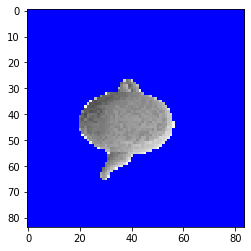

In [5]:
plt.imshow(np.load('teapot/small_teapot/teapot290.npy'))

# Learning Disentangled Representations

Note: This works faster using a GPU

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### First, define a TeapotWorld class that can load sequences of states and actions from our dataset

In [8]:
class TeapotWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions    

    class observation_space():
        def __init__(self,shape):
            self.shape = shape
    
    def __init__(self, action_file, data_dir):

        self.action_space = self.action_space(8)
        self.observation_space = self.observation_space([84,84,3])
        
        self.actions = np.load(action_file)
        self.data_dir = data_dir
        self.n_data = len(self.actions)
        self.dataset = self.load_dataset()
        
        self.current_idx = 0
        
        self.reset()

    def load_dataset(self):
        data = []
        for idx in tqdm(range(self.n_data)):
            data.append(self.load_image(idx))
        return torch.stack(data)
        
    def reset(self):
        self.current_idx = random.randrange(self.n_data-10)
        return self.get_observation()

    def load_image(self, idx):
        data_file = 'teapot'+str(idx)+'.npy'
        obs = np.load(self.data_dir+data_file)
        return torch.FloatTensor(obs/255)

    def get_observation(self, idx=None):
        if idx == None:
            idx = self.current_idx
        obs = self.dataset[idx]
        return obs.to(device)
    
    def get_action(self):
        return self.actions[self.current_idx]

    def step(self):
        self.current_idx += 1
        return self.get_observation()

    def get_batch(self, batch_size):
        idx = random.sample(range(self.n_data),batch_size)
        batch = []
        for i in idx:
            batch.append(self.get_observation(idx=i))
        batch = torch.stack(batch)
        return batch.to(device)

**Check that TeapotWorld loads correctly**

In [9]:
env = TeapotWorld('teapot/actions.npy','teapot/small_teapot/')

100%|██████████| 1000/1000 [00:01<00:00, 676.83it/s]


### Define encoder and decoder. 

These are based on the neural networks used in the "Human-level control through deep reinforcement learning" DQN paper, since the observations have pretty much the same dimensions

In [10]:
def init_weights(m, gain):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d) | (type(m) == nn.ConvTranspose2d):
        nn.init.orthogonal_(m.weight, gain)
        nn.init.zeros_(m.bias)

class Encoder(nn.Module):

    def __init__(self, n_out=5, n_hid = 128, weight_scale=5):

        super().__init__()

        self.conv = nn.Sequential(nn.Conv2d(3, 16, 8, stride=4),
                                  nn.ReLU(),
                                  nn.Conv2d(16, 32, 4, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(32, 32, 3, stride=1),
                                  nn.ReLU())

        self.output = nn.Sequential(nn.Linear(32 * 7 * 7, n_hid),
                                  nn.ReLU(),
                                  nn.Linear(n_hid, n_out))
        
        self.conv.apply(lambda x: init_weights(x, weight_scale))
        self.output.apply(lambda x: init_weights(x, weight_scale))

    def forward(self, obs):
        if len(obs.shape) != 4:
            obs = obs.unsqueeze(0)
        obs = obs.permute(0, 3, 1, 2)
        obs = obs/255
        obs = self.conv(obs)
        obs = obs.contiguous().view(obs.size(0), -1)
        return F.normalize(self.output(obs)).squeeze()

class Decoder(nn.Module):
    
    def __init__(self, n_in=5, n_hid = 128, weight_scale=5):

        super().__init__()
        
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, 32 * 7 * 7)

        self.conv = nn.Sequential(nn.ConvTranspose2d(32, 32, 3, stride=1),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(32, 16, 4, stride=2),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(16, 3, 8, stride=4),
                                  )
        
        self.conv.apply(lambda x: init_weights(x, weight_scale))
        init_weights(self.fc1, weight_scale)
        init_weights(self.fc2, weight_scale)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        batch_size = x.shape[0]
        x = x.reshape(batch_size,32,7,7)
        x = self.conv(x).permute(0,2,3,1)
        return torch.sigmoid(x).squeeze()

**Check dimensions**

In [11]:
encoder = Encoder(n_out=5).to(device)
decoder = Decoder(n_in=5).to(device)
print(encoder)
print(decoder)

Encoder(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
  )
)
Decoder(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1568, bias=True)
  (conv): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(8, 8), stride=(4, 4))
  )
)


In [12]:
obs = env.reset()
print(obs.shape)
latent = encoder(obs)
print(latent.shape)
reconstructed = decoder(latent)
print(reconstructed.shape)

torch.Size([84, 84, 3])
torch.Size([5])
torch.Size([84, 84, 3])


**Representation**

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

In [13]:
class Representation():

    def __init__(self, dim=5):
        self.dim = dim
        self.params = dim*(dim-1)//2
        self.thetas = torch.FloatTensor(2*torch.rand(self.params)-1).to(device).requires_grad_()

        self.__matrix = None
    
    def set_thetas(self, thetas):
        self.thetas = thetas
        self.thetas.requires_grad = True
        self.clear_matrix()
    
    def clear_matrix(self):
        self.__matrix = None
        
    def get_matrix(self):
        if self.__matrix is None:
            k = 0
            mats = []
            for i in range(self.dim-1):
                for j in range(self.dim-1-i):
                    theta_ij = self.thetas[k]
                    k+=1
                    c, s = torch.cos(theta_ij), torch.sin(theta_ij)

                    rotation_i = torch.eye(self.dim, self.dim).to(device)
                    rotation_i[i, i] = c
                    rotation_i[i, i+j+1] = s
                    rotation_i[j+i+1, i] = -s
                    rotation_i[j+i+1, j+i+1] = c

                    mats.append(rotation_i)

            def chain_mult(l):
                if len(l)>=3:
                    return l[0]@l[1]@chain_mult(l[2:])
                elif len(l)==2:
                    return l[0]@l[1]
                else:
                    return l[0]

            self.__matrix = chain_mult(mats)
                                    
        return self.__matrix

**LatentWorld**

Now, for symmetry's sake, we'll also have a `LatentWorld` which acts as the environment in the latent space.

In [14]:
class LatentWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))

    class observation_space():
        def __init__(self,n_features):
            self.shape = [n_features]
    
    def __init__(self,
                 dim=5,
                 n_actions=8,
                 action_reps=None):

        self.dim = dim

        self.action_space = self.action_space(n_actions)
        self.observation_space = self.observation_space(dim)
        
        if action_reps is None:
            self.action_reps = [Representation(dim=self.dim) for _ in range(n_actions)]
        else:
            if len(action_reps)!=n_actions:
                raise Exception("Must pass an action representation for every action.")
            if not all([rep.dim==self.dim]):
                raise Exception("Action representations do not act on the dimension of the latent space.")
            self.action_reps = action_reps
        
    def reset(self, state):
        self.state = state
        return self.get_observation()
    
    def clear_representations(self):
        for rep in self.action_reps:
            rep.clear_matrix()
            
    def get_representation_params(self):
        params = []
        for rep in self.action_reps:
            params.append(rep.thetas)
        return params
    
    def save_representations(self, path):
        if os.path.splitext(path)[-1] != '.pth':
            path += '.pth'
        rep_thetas = [rep.thetas for rep in self.action_reps]
        return torch.save(rep_thetas, path)
    
    def load_reprentations(self, path):
        rep_thetas = torch.load(path)
        for rep in self.action_reps:
            rep.set_thetas(rep_thetas.pop(0))
            
    def get_observation(self):
        return self.state
    
    def step(self,action):
        self.state = torch.mv(self.action_reps[action].get_matrix(), self.state.squeeze())
        obs = self.get_observation()
        return obs

**Entanglement regularisation**

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

In [15]:
def calc_entanglement(params):
    params = params.abs().pow(2)
    return params.sum() - params.max()

params = torch.FloatTensor([1,1,0.5,0,0])
calc_entanglement(params)

tensor(1.2500)

### Training with regularization

We find it helpful to increase the regularization strength halfway during training

In [16]:
dim=5

obs_env = TeapotWorld('teapot/actions.npy','teapot/small_teapot/')
lat_env = LatentWorld(dim = dim,
                      n_actions = obs_env.action_space.n
                     )
decoder = Decoder(n_in = dim, n_hid = 128).to(device)
encoder = Encoder(n_out = dim, n_hid = 128).to(device)

optimizer_dec = optim.Adam(decoder.parameters(),
                           lr=1e-3,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_enc = optim.Adam(encoder.parameters(),
                           lr=1e-3,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

optimizer_rep = optim.Adam(lat_env.get_representation_params(),
                           lr=1e-2,
#                            betas=(0.9, 0.99),
                           weight_decay=0)

losses = []
entanglement = []
orthogonality = []

100%|██████████| 1000/1000 [00:00<00:00, 1754.53it/s]


In [17]:
import time

n_sgd_steps = 10000
ep_steps = 5
batch_eps = 16

i = 1

t_start = time.time()

temp = 0

while i < n_sgd_steps:
    loss = torch.zeros(1).to(device)

    for _ in range(batch_eps):
        t_ep = -1
        while t_ep < ep_steps:
            if t_ep == -1:
                obs_x = obs_env.reset()
                obs_z = lat_env.reset(encoder(obs_x))
            else:
                action = obs_env.get_action()
                obs_x = obs_env.step()
                obs_z = lat_env.step(action)
            
            t_ep += 1         
            
            obs_x_recon = decoder(obs_z)

            loss += F.binary_cross_entropy(obs_x_recon, obs_x)
        
    loss /= (ep_steps * batch_eps)
    loss_raw = loss

    reg_loss = sum([calc_entanglement(r.thetas) for r in lat_env.action_reps])/8
    if i < 5000:
        loss += reg_loss*1e-3
    else:
        loss += reg_loss*3e-2
                        
    losses.append(loss_raw.item())
    entanglement.append(reg_loss.item())
    
    optimizer_dec.zero_grad()
    optimizer_rep.zero_grad()
    optimizer_enc.zero_grad()
    loss.backward()
    optimizer_dec.step()
    optimizer_rep.step()
    optimizer_enc.step()
        
    # Rember to clear the cached action representations after we update the parameters!
    lat_env.clear_representations()

    i+=1
    
    if i%10==0:
        print("iter {} : loss={:.3e} : entanglement={:.2e} : last 10 iters in {:.3f}s".format(
            i, loss.item(), reg_loss.item(), time.time() - t_start
            ), end="\r" if i%100 else "\n")
        t_start = time.time()

iter 100 : loss=8.301e-01 : entanglement=1.50e+00 : last 10 iters in 3.398s
iter 200 : loss=8.234e-01 : entanglement=1.10e+00 : last 10 iters in 3.412s
iter 300 : loss=7.464e-01 : entanglement=7.17e-01 : last 10 iters in 3.326s
iter 400 : loss=6.625e-01 : entanglement=5.25e-01 : last 10 iters in 3.296s
iter 500 : loss=6.165e-01 : entanglement=4.72e-01 : last 10 iters in 3.372s
iter 600 : loss=4.312e-01 : entanglement=4.46e-01 : last 10 iters in 3.389s
iter 700 : loss=3.550e-01 : entanglement=4.39e-01 : last 10 iters in 3.328s
iter 800 : loss=2.399e-01 : entanglement=4.42e-01 : last 10 iters in 3.372s
iter 900 : loss=1.676e-01 : entanglement=4.29e-01 : last 10 iters in 3.408s
iter 1000 : loss=1.614e-01 : entanglement=5.21e-01 : last 10 iters in 3.788s
iter 1100 : loss=1.492e-01 : entanglement=7.08e-01 : last 10 iters in 3.340s
iter 1200 : loss=1.425e-01 : entanglement=7.89e-01 : last 10 iters in 3.372s
iter 1300 : loss=1.357e-01 : entanglement=8.48e-01 : last 10 iters in 3.384s
iter 140

### Show reconstructed states

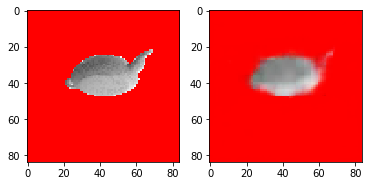

In [18]:
obs = env.reset()
latent = encoder(obs)
reconstructed = decoder(latent)

fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(obs.to('cpu'))
ax2.imshow(reconstructed.detach().to('cpu'))

### Show action representations

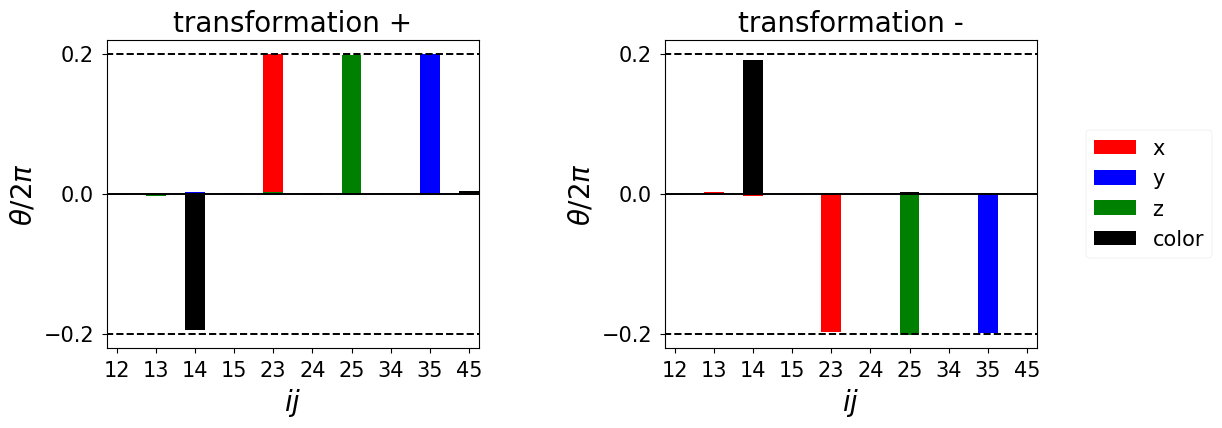

In [20]:
width=0.5

rep_thetas = [rep.thetas.detach().to('cpu').numpy() for rep in lat_env.action_reps]
#print(rep_thetas)
plt_lim = max( 0.22, max([max(t) for t in rep_thetas])/(2*np.pi) )
titles = ["transformation +", "transformation -"]
cols=["r","b","g","black"]
labels=["x","y","z","color"]

with plt.style.context('seaborn-paper', after_reset=True):

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace":0.5, "hspace":0.5})
    
    for i, thetas in enumerate(rep_thetas):
        x = np.arange(len(thetas))
        axs[i%2].bar(x - width/2, thetas/(2*np.pi), width, label=labels[i//2], color=cols[i//2])
    for i in range(2):
        axs[i].hlines([0.2,-0.2], xmin=-10, xmax=10, linestyles="dashed")
        axs[i].hlines(0., xmin=-10, xmax=10)
        axs[i].set_yticks([-0.2, 0., 0.2])
        axs[i].set_xticks(x-0.25)
        axs[i].set_xticklabels(["12","13","14","15","23","24","25","34","35","45"], fontsize=10)
        axs[i].set_xlabel("$ij$", fontsize=20)
        
        axs[i].set_ylim(-plt_lim,plt_lim)
        axs[i].set_xlim(-0.5,9)
        axs[i].set_title(titles[i], fontsize=20)
        axs[i].tick_params(labelsize=15)
        
        axs[i].set_ylabel(r"$\theta / 2\pi$", fontsize=20)
    
    axs[1].legend(loc="center right", bbox_to_anchor=(1.5,0.5), fontsize=15)

plt.savefig("teapot/representations.png", bbox_inches='tight')

### For the paper, generate sequence of images from the dataset

In [ ]:
import matplotlib.gridspec as gridspec
from IPython import display

plt.figure(figsize = (6,6))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0.02, hspace=0.02)
plt.grid(None)
state = env.reset()
for i in range(9):
    ax = plt.subplot(gs1[i])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.imshow(state.to('cpu'))
    display.display(plt.gcf())
    time.sleep(0.2)
    display.clear_output(wait=True)
    state = env.step()
    
plt.savefig("teapot/env.png", bbox_inches='tight')